In [1]:
from myst_nb import glue

(image_processing)=
# Image processing

## Image processing

### Mathematical concepts of images

We start with an adequate definition of an image, respectively of important structural parts of an image. In view of mathematical generalisation we will not make a specific difference between classical images (2d) and volumetric images (3d). Even movies, e.g. $(2+1)d$ or $(3+1)d$ image sequences, will be called images. We will denote the image dimension with $d\in \{2,3,4\}$. For the mathematical modelling of images we distinguish the following two cases:

* The idealised (continuous) image as a function $u(x)$, $u:\Omega \rightarrow \mathbb{R}$, where $\Omega \subset \mathbb{R}^d$ denotes the domain of the image (usually a rectangle or cube).
* The digital (discrete) image as a matrix (tensor) $u_{i_1,\cdots i_d}$, $u \in \mathbb{R}^{N_1 \times N_2 \times \cdots \times N_d}$.

Between the idealised and digital version of images there exists an obvious connection, which is also defined via the visualisation of images. For this, one divides the domain $\Omega$ into $N_1 \times N_2 \times \cdots \times N_d$ small rectangles (pixels) or cubes (voxels), where the grayvalues get defined (coloured) via the corresponding entry of $U$.
Hence, every discrete image immediately corresponds to a continuous image, which in each pixel (for simplicity we do not differentiate between pixel and voxel from now on) is constant. Conversely, one can also generate a discrete image from any continuous image by computing the mean value of $u$ over each pixel.

At first sight, this definition of an idealised (continuous) image seems to be an arbitrary mathematical idealisation. However, in practice it turns out that the definition is fundamental for many different aspects of image processing, e.g. the following:

**Resolution.** Digital (discrete) images can be available in many different resolutions, i.e. with different amount of pixels. To understand the correspondence between different resolutions, it is very useful to interpret all possible digital images as discrete versions (via mean value computation in pixels) of one underlying continuous image. Via this consistency in the transition between continuous and digital images, also transitions between digital images of different resolutions is clearly defined.

**Features.** Many properties of images which can intuitively be perceived clearly, are difficult to define in digital images. An important example of this observation are edges, which we understand as transitions between very different grayvalues. While the definition of edges in the continuous image as the set of discontinuities of the function $u$ is obvious and unique, the definition in the discrete case is difficult and not unique, because often the value changes from one pixel to the next. Therefore, an edge in the digital image can be better obtained as an averaging of the edge in the continuous image over pixels in the respective resolution.

**Modelling.** The mathematical modelling of image processing tasks can be performed in the continuous setup in a unified manner. Here one has all fundamental concepts around integration and differentiation available. We will see that those are in nearly all techniques of enormous importance. Once a variational model has been constructed for a continuous image, via discretisation it can be consistently transferred to all discrete images, independent of the resolution. In particular, also the condition of such a problem is interesting, which, for high resolution with reasonable discretisation, converges to the condition of the continuous problem. Hence, one should try to analyse the condition of the continuous problem, which can be realised especially via an adequate choice of regularisation functionals and leads to interesting mathematical questions, which however in most practical applications can be answered sufficiently.

**Algorithms.** Also the design of algorithms gets more consistent if one assumes an underlying continuous image. For example, for an iterative algorithm, while increasing resolution, one wants to avoid a significant increase in number of necessary iterations to achieve a certain resolution. This is guaranteed if one obtains an algorithm as a discretisation of an algorithm for the continuous image. The latter has to be constructed as an algorithm for functions, i.e. in function spaces, in analogy to methods for partial differential equations.

### Noise models and error measures

We understand noise as the undesired disturbances of intensities in an image. In nearly all imaging devices, like microscopes, different tomographs or even simple digital cameras, one obtains noise effects in measured data. In the following we will introduce the characterisation of different noise models in images.

Among different inverse problems in imaging, dependent on the underlying physics, one can observe different types of noise in measured imaging data. Considering the noise as a statistical random process specific noise types can be characterised by specific distributions. To model the noise a-priori, typical choices are Gauss-, Laplace- or Poisson-distributions, but also combinations of those. Obvious errors in the imaging process are intensity errors. One can see those errors as realisations of independent random variables, acting on each pixel separately.

The simplest model of intensity errors is additive noise. For a discrete image $U$ and noise $\delta$ the measured data $F$ is simply given point-wise by

$$
    F = U + \delta \ .
$$

If every random variable follows a Gauss-distribution, it is called additive Gaussian noise. Other common additive noise models are given by assuming a Laplace-, uniform- or also Poisson-distribution (with constant parameter) instead. In analogy, a model for multiplicative noise is given by

$$
	F = U \cdot \delta \ .
$$

A typical case for multiplicative noise is given by Gamma distributed random variables. Particularly, in view of several biomedical imaging methods there are known noise models, like Poisson noise or salt-and-pepper noise, which are defined by a dependency on $U$

$$
	F = \delta(U) \ ,
$$

i.e. those are neither additive nor multiplicative. Errors in photon counting, for instance in several areas of tomography, microscopy, but also in CCD sensors of digital cameras or astronomy systems, are typically modelled as Poisson noise. Some examples of various noise types applied to a test images are shown below.

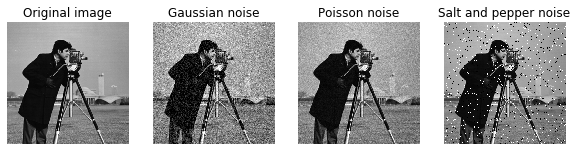

In [2]:
# import libaries
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import random_noise

# load test image 
camera = data.camera()

# plot
sigma = .1

fig, ax = plt.subplots(1,4,figsize=(10,10))

for i in range(len(ax)):
    ax[i].axis('off')

plt.gray()

ax[0].imshow(camera)
ax[0].set_title('Original image')

ax[1].imshow(random_noise(camera, mode='gaussian', var=sigma**2))
ax[1].set_title('Gaussian noise')

ax[2].imshow(random_noise(camera, mode='poisson'))
ax[2].set_title('Poisson noise')

ax[3].imshow(random_noise(camera, mode='s&p'))
ax[3].set_title('Salt and pepper noise')

plt.show()
glue("noisy_images", fig, display=False)

Before we focus on different filtering methods, we should discuss different methods for validating the quality of a method. A simple validation would for sure be a number, which becomes zero in case of perfect denoising, respectively increases with worse quality (or vice versa). To test a denoising method with artificial data one can simply compute the distance between the denoised and the clean image, with regard to an adequate norm. If we use the notation $f$ for the clean image, $f^{\delta}$ for the noisy data, and $u$ for the denoising via a particular method, then an error measure is simply given by

$$
	e_{abs} = \Vert u - f^{\delta} \Vert.
$$

To avoid scaling issues (and error propagation) it is often more reasonable to consider a relative error with respect to the noise, i.e.

$$
e_{rel} = \frac{\Vert u - f^{\delta} \Vert}{\Vert f - f^{\delta}\Vert}
$$

or the scaled error

$$
e_{skal} = \frac{\Vert u - f^{\delta} \Vert}{\Vert f^{\delta} \Vert} .
$$

A variant of the scaled error is the commonly used Signal-to-Noise ratio (SNR). The naming is based on the idea that $\Vert u - f^{\delta} \Vert_2$ measures something like the noise of the method (note that $\Vert f - f^{\delta}\Vert_2$ is the actual noise) and that $\Vert f^{\delta} \Vert_2$ measures the amount/essence of signal. Here $\Vert \cdot \Vert_2$ is in the idealised (continuous) case the $L^2$-norm;

$$
	\Vert u \Vert_2 = \sqrt{\int_\Omega u(x)^2~dx}
$$

and in the discrete case the scaled $\ell^2$-norm

$$
	\Vert U \Vert_2 = \sqrt{\frac{1}{N_1 N_2} \sum_{i,j} U_{i,j}^2} \ .
$$

Then as SNR one obtains

$$
	SNR(u,\hat f) = - \log \left( \frac{\Vert u - \hat f \Vert_2}{\Vert \hat f \Vert_2} \right).
$$

Note the reversal of monotony. The SNR is large for good quality and low for bad quality of a reconstruction. An additional widely used variant of the SNR is the Peak-Signal-to-Noise ratio (PSNR)

$$
PSNR = - \log \left( \frac{\Vert u - \hat f \Vert_2}{\Vert \hat f \Vert_\infty }\right).
$$

Here one compares the noise with the peak in an image, i.e. $\Vert \hat f \Vert_\infty = \sup |f^{\delta}|$. The described error measures are reasonable for additive noise models (e.g. Gauss, Laplace), because one can show a correspondence to $L^1$ and $L^2$ norms in a statistical sense. For other noise types, one should take into account other error measures, for instance we will see in later chapters, that the Kullback-Leibler distance represents an adequate error measure for Poisson noise. In some cases it will be necessary to consider error measures different from standard norms, e.g. if one is primarily interested in edges of a reconstruction. In such cases more geometric error measures (in more general metrics) are favourable for the distances of edge sets.

### Local smoothing filters
In this section we focus on filtering methods for image denoising. Denoising is one of the most important tasks in digital image processing because it finds various applications beyond fluorescence microscopy and forms a well understood basis for many other image processing challenges in inverse problems. Denoising is the (inverse) problem of removing the noise from images while keeping significant information in the data. In applications, denoising methods are often applied as pre- or postprocessing methods to better analyse images and to be able to extract specific features, e.g. edges or corners, more effectively. In the following we particularly focus on the relationship between denoising filters, partial differential equations (PDEs) and related variational methods. We will start with simple linear diffusion filters an end with an outlook on a famous nonlinear variational method for denoising.

The term filter has its origin in signal analysis, as a procedure which yields only a part of the signal (resp. the image). The hope in denoising is for sure to filter the clean from the noisy signal. Local smoothing filters are based on the idea, that in a local neighbourhood similar gray- or colourvalues occur. Therefore one can try to replace the image by a local averaging. In this process also random distortions (the noise) will be averaged out. If one assumes, as introduced above, noise based on independent and identically distributed (iid) random variables, then also the variance of the signal should be reduced in this way. A local linear smoothing filter has the general forms

$$
	u = G_\epsilon*f, \label{lokalerGlaettungsfilter}
$$

where $G_\epsilon*f$ is the convolution of the noisy image with a kernel $G_\epsilon = \frac{1}{\epsilon^d} G(\frac{\cdot}\epsilon)$ of specific form.
To obtain a reasonable convex combination $G$ should be nonnegative and should have a mean value of $1$. To obtain locality, $G$ should attain its maximum around the origin and should decrease towards zero for larger arguments. A simple and commonly used example of such a function is again the Gauss distribution, but also other convolution kernels with local compact support are of interest. The parameter $\epsilon$ measures the scale on which averaging takes place. The convolution can be defined in the idealised (continuous) case as

$$
	G_\epsilon*f = \frac{1}{\epsilon^d} \int_\Omega G\left(\frac{x-y}\epsilon\right) f(y)~dy
$$

or in the discrete case as

$$
	(G_\epsilon*F)_{ij} = \frac{1}{\epsilon^d} \sum_{k,\ell} G\left(\frac{x_{ij}-x_{k\ell}}\epsilon\right) F_{k\ell} \, .
$$

In the discrete case it is important to choose $\epsilon$ adequately dependent on the underlying grid size. If $\epsilon$ is too small no effective smoothing can be expected.

In practice local smoothing methods actually reduce the noise, however there is also a potential problem of such filters, namely oversmoothing. In particular this affects edges, since at an edge the assumption having locally similar gray values is mostly violated. For example, if we think of a black-white edge, local grayvalues will be averaged to gray at the edge. In this way the edge (discontinuity) is getting averaged to a continuous transition of grayvalues, which as a result looks like an optically blurred edge.

### Special local filter and additive noise
For further understanding we consider the discrete case and the special local filter of the form

$$
	U_{ij} = (1-4 \alpha) F_{ij} + \alpha( F_{i-1j} + F_{i+1j} + F_{ij-1} + F_{ij+1}),
$$

i.e. the filter only acts on neighbouring pixels. Hereby $\alpha \in (0,\frac{1}5)$ is the parameter which controls the weighting. The scaling parameter $\epsilon$ can be identified with the size of the grid. We assume that the observation/measurement originates from point-wise Gaussian noise, i.e.

$$
	F_{ij} = \hat F_{ij} + \delta^\sigma_{ij} \, .
$$

With the filter we obtain a systematic error, i.e.

$$
	\mathbb{E}(\hat{U}_{ij}) &=& (1-4 \alpha) \mathbb{E}(F_{ij}) + \alpha( \mathbb{E}(F_{i-1j}) + \mathbb{E}(F_{i+1j}) + \mathbb{E}(F_{ij-1}) + \mathbb{E}(F_{ij+1})) \\ &=& (1-4 \alpha) \hat F_{ij} + \alpha( \hat F_{i-1j} + \hat F_{i+1j} + \hat F_{ij-1} + \hat F_{ij+1}),
$$

and hence in general $\mathbb{E}(\hat{U}_{ij}) \neq \hat F_{ij}$. So the filter has a particular disadvantage, which one should only accept, if at least the mean error gets smaller, so we should analyze the following term.

$$
\mathbb{E}((\hat{U}_{ij} - \hat F_{ij})^2) &=&  \mathbb{E}((\hat{U}_{ij} - \mathbb{E}(\hat{U}_{ij}) + \mathbb{E}(\hat{U}_{ij})- \hat F_{ij})^2) \\
&=& \mathbb{E}((\hat{U}_{ij} - \mathbb{E}(\hat{U}_{ij}))^2) + (\mathbb{E}(\hat{U}_{ij})- \hat F_{ij})^2
$$

We start with the first term and obtain due to independence of the $F_{ij}$ and $\mathbb{E}(F_{ij}) = \hat F_{ij}$:

$$
\hat{U}_{ij} - \mathbb{E}(\hat{U}_{ij}) &=& (1-4 \alpha) (F_{ij}-\hat F_{ij}) + \alpha( F_{i-1j} - \hat F_{i-1j} + F_{i+1j} - \hat F_{i+1j} + \\ && F_{ij-1} - \hat F_{ij-1} + F_{ij+1}- \hat F_{ij+1}) \\ &=&
(1-4 \alpha) \delta_{ij}^\sigma + \alpha( \delta_{i-1j}^\sigma + \delta_{i+1j}^\sigma + \delta_{ij-1}^\sigma + \delta_{ij+1}^\sigma),
$$

where $\delta_{ij}^\sigma$ are independent normal distributed random variables with mean value $0$ and standard deviation $\sigma$. Then we obtain

$$
\mathbb{E}((\hat{U}_{ij} - \mathbb{E}(\hat{U}_{ij}))^2) &=& (1-4\alpha)^2 \mathbb{E}((\delta_{ij}^\sigma)^2) + \alpha^2 (~\mathbb{E}((\delta_{i+1j}^\sigma)^2) + \mathbb{E}((\delta_{i-1j}^\sigma)^2)+\\&& \mathbb{E}((\delta_{ij+1}^\sigma)^2)+\mathbb{E}((\delta_{ij-1}^\sigma)^2)~) \\
&=& (1-4\alpha)^2 \sigma^2 + 4 \alpha \sigma^2 = (1-8\alpha +20 \alpha^2) \sigma^2.
$$

The noise gets reduced by the filter, because this part of the error is smaller than $\sigma$ for $\alpha > 0$. Now we consider also the second term in the estimate above, which describes the systematic error. It holds that

$$ \mathbb{E}(\hat{U}_{ij})- \hat F_{ij} = \alpha ( \hat{F}_{i-1j} + \hat{F}_{i+1j} + \hat{F}_{ij-1} + \hat{F}_{ij+1}-4\hat{F}_{ij}) . 
$$

For simplicity we assume that $\hat{F}_{ij}$ is the pixel value at index $(ih,jh)$, where $h$ denotes the (small) pixel size. So we have the idea that $\hat{F}_{ij} = \hat{f}(x_{ij})$ for an adequate grayvalue function $\hat{f}$. If $\hat{f}$ is twice continuously differentiable, then with the mean value theorem we have the existence of $\xi_1 \in ((i-1)h,(i+1)h) \times \{jh\}$ and $\xi_2 \in \{ih\} \times ((j-1)h,(j+1)h)$, such that

$$ 
\hat{F}_{i-1j} + \hat{F}_{i+1j} - 2 \hat{F}_{ij} = \frac{\partial^2\hat{f}}{\partial x_1^2}(\xi_1) h^2 
$$

and
$$ 
\hat{F}_{ij-1} + \hat{F}_{ij+1}- 2 \hat{F}_{ij} = \frac{\partial^2\hat{f}}{\partial x_2^2}(\xi_2) h^2 .
$$

Thus we can estimate the second part o the error by

$$
(\mathbb{E}(\hat{U}_{ij})- \hat F_{ij})^2 \leq 4 \max\left\{ \|\frac{\partial^2\hat{f}}{\partial x_1^2}\|_\infty,\|\frac{\partial^2\hat{f}}{\partial x_2^2}\|_\infty \right\} \alpha^2 h^4  .
$$

As a result we finally obtain the estimate

$$
 \mathbb{E}((\hat{U}_{ij} - \hat F_{ij})^2) \leq (1-8\alpha+20 \alpha^2) \sigma^2 + 4 \max\left\{ \|\frac{\partial^2\hat{f}}{\partial x_1^2}\|_\infty,\|\frac{\partial^2\hat{f}}{\partial x_2^2}\|_\infty \right\} \alpha^2 h^4.
$$

In particular for $h$ sufficiently small, the mean square error is smaller than $\sigma^2$ and therefore it seems reasonable to use the filter. However, one also observes, that the second derivative of $f$ is essential, such that one should expect problems at less smooth image parts like edges. Those problems actually appear in practice and lead to significant blur. This is why many other (nonlinear, nonlocal) filters have been developed which can better deal with features like edges. An example of the linear filter outlined above applied to a noisy image is shown below.

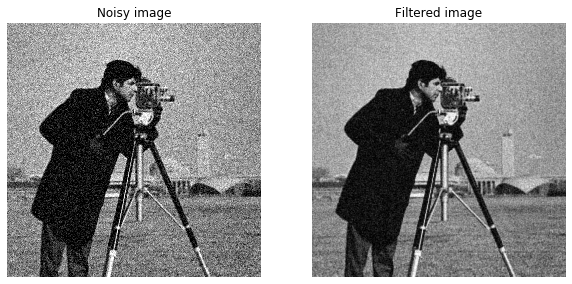

In [3]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import random_noise
from scipy.signal import convolve2d as conv2

# load test image 
camera = data.camera()

# add noise
sigma = .1
camera_noisy = random_noise(camera, mode='gaussian', var=sigma**2)

# filter 
alpha = .2
filter = np.array([[0, alpha, 0],[alpha, 1-4*alpha,alpha],[0,alpha,0]])
camera_filtered = conv2(camera_noisy, filter, 'same')

# plot
fig, ax = plt.subplots(1,2,figsize=(10,10))

for i in range(len(ax)):
    ax[i].axis('off')

plt.gray()

ax[0].imshow(camera_noisy)
ax[0].set_title('Noisy image')

ax[1].imshow(camera_filtered)
ax[1].set_title('Filtered image')

plt.show()
glue("linear_filter", fig, display=False)

### Frequency space filters.
A useful analysis of images can be achieved by applying the Fourier transform $F$

$$
	F(u)(\xi) := (2\pi)^{-\frac{n}{2}} \int_{\mathbb{R}^n} u(x) \exp(-ix \cdot \xi) \, \mathrm{d}x
$$

which transfers a function into the frequency space. Here, the value of the Fourier transform at $\omega$ provides the proportion of an oscillation with frequency $\omega$. The Fourier transform has also an explicit inverse $F^{-1}$ of the form

$$
	F^{-1}(f)(x) := (2\pi)^{-\frac{n}{2}} \int_{\mathbb{R}^n} f(\xi) \exp(ix \cdot \xi) \, \mathrm{d}\xi ~.
$$

Very similar to smoothing filters, or actually just another way of looking at things, are frequency space filters which are given in the following form

$$
	u = F^{-1} ( \psi_\epsilon F(f))
$$

where $\psi_\epsilon$ denotes a function which dampens or completely eliminates particular frequencies (again dependent on a scale parameter $\epsilon$). The connection with the filter definition \eqref{lokalerGlaettungsfilter} is given by the convolution theorem because with $G_\epsilon := (2 \pi)^{-d/2} {\cal F}^{-1} (\psi_\epsilon)$ it follows that

$$
	G_\epsilon*f = (2 \pi)^{-d/2} F^{-1} (F(G_\epsilon) F(f)) = F^{-1} ( \psi_\epsilon F(f)) \, .
$$

The original motivation of constructing frequency space filters is slightly different from those of local smoothing. In frequency space the central idea is that noise often corresponds to high frequencies and therefore one should at least dampen those frequencies. Such filters are called *lowpass filters* since only the small frequencies remain unchanged (in analogy to a hardware filter for signals where only low frequency components can pass). The simplest choice of a function $\psi_\epsilon(\omega) = \psi(\epsilon\omega)$ one receives with

$$
	\psi(\omega)  = \left\{ \begin{array}{ll} 1 & \text{for } |\omega| \leq 1 \\ 0 &\text{otherwise} \end{array} \right.
$$

In this way $\psi_\epsilon$ cuts off all frequency components above $1/\epsilon$ (note the inverse relation since $\epsilon$ corresponds to the wavelength), and those below $1/\epsilon$ remain unchanged. By computing the inverse Fourier transform one can see that in the form \eqref{lokalerGlaettungsfilter} a sinc function ($G(x) \sim \sin |x| / |x|$) is obtained as convolution kernel. Due to the local oscillation of the sine this yields a slightly unusual local averaging, since the weighting does not decay monotonously with the distance. Hence, without the frequency space interpretation one would likely not have constructed a filter of this form. However, both viewpoints also strongly depend on each other, since the lack of high frequency components automatically implies that the local variation of the grayvalue cannot be extremely strong and vice versa. Thus, the original viewpoint and the frequency space interpretation are based on very similar assumptions. The connection again gets even more obvious for a Gauss distribution as convolution kernel. The Fourier transform of this function again results in a Gauss distribution (besides a constant). Hence, in frequency space one dampens again with this quickly decreasing function.

### Diffusion filters and PDE methods
Interestingly, one can interpret local smoothing filters also in the context of PDE methods in form of so-called linear diffusion filters. For this, one can see $\alpha$ as a fixed given quantity and simply repeat the filter several times to reduce the variance step-by-step. This yields an iterative procedure, where the filter is always applied to the solution of the previous filter step. With $U^0:=F$ we then obtain

$$
	U_{ij}^{k+1} = (1-4 \alpha) U^k_{ij} + \alpha( U^k_{i-1j} + U^k_{i+1j} + U^k_{ij-1} + U^k_{ij+1}).
$$

Under the assumption that $h$ is sufficiently small and that $\alpha \leq \frac{1}5$, one can consider the continuous limit. It holds that
$$
	\frac{U_{ij}^{k+1}- U^k_{ij}}{h^2 \alpha} = \frac{1}{h^2} (U^k_{i-1j} + U^k_{i+1j} + U^k_{ij-1} + U^k_{ij+1} - 4U_{ij}^k) = \Delta u (x_{ij}) + {\cal O}(h^2),
$$

where $\Delta = \nabla \cdot \nabla$ denotes the Laplace operator. With $\tau = \alpha h^2 << 1$ we can also interpret this equation as a forward Euler discretisation of the heat equation (diffusion equation)

$$
	\tau = \alpha h^2 << 1
$$

with initial value $u(0) = f$. So we obtain a method based on a partial differential equation (PDE). Also for this kind of methods the question of an optimally chosen parameter remains, namely the optimal stopping index in case of the discrete iteration, respectively the optimal termination time of the diffusion equation. The iterative application of the local smoothing filter from the previous subsections we could interpret as a heat diffusion equation. This parabolic differential equation is a simple representative of a linear diffusion filter. As we could see in figure \ref{fig:laplace} edges get blurred by a linear filter. Particularly in biomedical imaging edges could deliver essential information for the image analysis. Therefore it makes sense to use nonlinear filters for denoising instead, which try to avoid the blurring of edges in normal direction. A prominent example for a nonlinear diffusion filter is the Perona-Malik model

$$
	\frac{\partial u}{\partial t} = \nabla \cdot \left( g(|\nabla u|^2) \nabla u\right), \qquad u(t=0) = f, \qquad g(s) = \frac{1}{1+\lambda \: s} \label{peronamalik}
$$

where $\lambda > 0$ denotes a weighting parameter. The main motivation of the Perona-Malik model is to achieve a smoothing via diffusion in regions with small grayvalue variations, but to avoid smoothing of edges ($g(|\nabla u|^2) \rightarrow 0$ for $|\nabla u| \rightarrow \infty$). Hence, the model reduces the diffusivity in regions where edges are present with high likelihood.

As we have seen, linear and nonlinear filters lead, in reasonable asymptotics, to the solution of parabolic differential equations of the form

$$
	\frac{\partial u}{\partial t} = F(\nabla u, D^2 u), \qquad u(0) = f, \label{pdeparabolic}
$$

where the denoised image then corresponds to the solution of this equation at a specific point in time $T > 0$. Because in such cases smoothing is achieved via diffusion, they are called diffusion filters. Also the term scale space method is quite common here because the method eliminates for increasing $T$ the smaller scales and the remaining scales get more coarse.

### Denoising via variational methods
In the previous subsection we have related the local smoothing filter to a PDE method. Now we would like to transition to an interpretation in the sense of variational methods. In comparison to the previous subsection we now assume that the parameter $\alpha$ might be variable. For sure one should then choose it optimally. The optimal choice of the parameter has to balance out the two competing effects of the filter. On the one hand, the filter has the positive effect of smoothing out the variance of the noise via averaging, and the variance decreases with $\alpha$ (and attains its minimum at $\alpha = \frac{1}5$, as one can derive from the first part of the mean squared error). On the other hand, the systematic error (see second part of mean square error) increases with $\alpha$. Hence, one can expect an optimal $\alpha$ dependent on the data somewhere in the interval $(0,\frac{1}5)$. This can also be recognised by another characterisation of the denoising as the minimum of the functional (under adequate treatment of grid points at the boundary)

$$
	J(U) &=&  \frac{1}2 \sum_{i,j} (U_{ij} - F_{ij})^2 + \frac{\alpha}2 \sum_{i,j} [ (F_{i+1j}-F_{ij})^2 + (F_{ij+1}-F_{ij})^2] +\nonumber \\ && \alpha \sum_{i,j} [ (F_{i+1j}-F_{ij})(U_{i+1j}-U_{ij}) + (F_{ij+1}-F_{ij})(U_{ij+1}-U_{ij})].
$$

The regularization functional, i.e.

$$
	R(U) = J(U) - \frac{1}2 \sum_{i,j} (U_{ij} - F_{ij})^2
$$

can be interpreted as a Taylor expansion of first order of the functional

$$
	\tilde R(U) =  \frac{\alpha}2 \sum_{i,j} [ (U_{i+1j}-U_{ij})^2 + (U_{ij+1}-U_{ij})^2]
$$

around $F$. Since for a small $\alpha$ value the minimum $U$ will be close to $F$, the difference between $R(U)$ and $\tilde R(U)$ should be small. It is reasonable to assume that $U$ lies close to the minimum of $J - R + \tilde R$, a functional which we will become acquainted with in later chapters regarding the modelling of maximum a-posteriori (MAP) estimators. Following the continuous limit, i.e. grid size $h \rightarrow 0$, this functional can be written dependent of functions $f$ (given) and $u$ (unknown)

```{math}
:label: L2L2Denoising
	\frac{1}{2} \int_\Omega (u-f)^2~dx \:+\: \frac{\alpha}{2}\int_\Omega |\nabla u|^2~dx ~\rightarrow~ \min_u \ .
```

Till now, in all previous methods, we have always focussed on additive Gaussian noise. Although the described filter methods can often be realised in a simple and efficient way, variational methods have important advantages in comparison. With variational methods one has the flexibility to model data fidelity terms and regularisation terms. According to a-prior knowledge about the noise as well as about the type (e.g. features) of images to be expected, those terms can easily be adapted, extended and combined.

Now we consider for $\alpha > 0$ a general variational problem for denoising

```{math}
:label: denoisingFunktionalAllgemein
	D(u,f) \:+\: \alpha \: R(u) ~\rightarrow~ \min_u \ .
```

The data fidelity term should be chosen in a way that $D$ becomes minimal if the data gets denoised exactly. Often specific noise models are reasonable for specific applications which gets reflected by different data fidelities. In a later chapter on modelling we will see that via statistical modelling for instance the following data fidelities can be derived:

* Additive Gaussian noise leads to $D(u,f) = \frac{1}{2}\left\| u-f \right\|^2_2$
* Additive Laplacian noise leads to $D(u,f) = \left\| u-f \right\|_1$
* Poisson noise leads to $D(u,f) = \int_\Omega \left( f \log \frac{f}u \: - \: f \: + \: u \right) \: \mathrm{d}x.$

The regularisation functional in {eq}`denoisingFunktionalAllgemein` should be constructed in such a way that $R$ has a small value, if the image matches the a-priori information about the "type of image" very well. In the quadratic regularisation in {eq}`L2L2Denoising` we also have a homogeneous smoothing similar to the linear smoothing filter, i.e. noise but also edges in in the image get penalised. Often this regularisation with the $L^2$-norm of the gradient is called $H^1$ regularisation, because it assumes implicitly that $u$ should be an element of the Sobolev function space $H^1 = W^{1,2}$. One of the most famous variational method for denoising is the Rudin-Osher-Fatemi (ROF) model

$$
	\frac{1}{2} \int_\Omega (u-f)^2 \:+\: \alpha \: \text{TV}(u) ~\rightarrow~ \min_u \ ,
$$

with the total variation as regularisation term

$$
	\text{TV}(u) \equiv \sup_{\substack{g \in {C_0^\infty(\Omega,\mathbb{R}^d)}\\||g||_\infty \leq 1}} \: \int_\Omega u \nabla \cdot g \ .
$$

If one restricts to the function space $W^{1,1}$, one can identify $\text{TV}(u)$ with $\|\nabla u\|_1$. With this variational problem it is possible to denoise images with homogeneous regions and sharp edges (cartoon images) particularly well. We will see in a later chapter on analysis that this variational problem has an interesting underlying function space, the space of functions of bounded variation (BV). An example of the effect of the ROF filter is shown below.

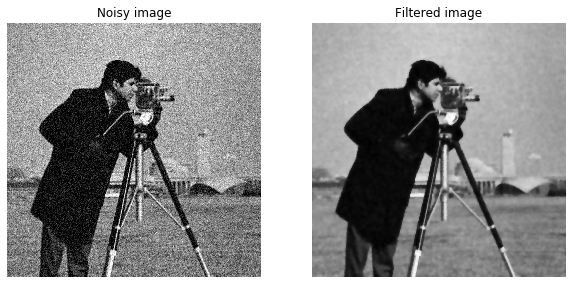

In [4]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle

# load test image 
camera = data.camera()

# add noise
sigma = .1
camera_noisy = random_noise(camera, mode='gaussian', var=sigma**2)

# filter 
alpha = .2
camera_filtered = denoise_tv_chambolle(camera_noisy, weight=alpha)

# plot
fig, ax = plt.subplots(1,2,figsize=(10,10))

for i in range(len(ax)):
    ax[i].axis('off')

plt.gray()

ax[0].imshow(camera_noisy)
ax[0].set_title('Noisy image')

ax[1].imshow(camera_filtered)
ax[1].set_title('Filtered image')

plt.show()

### Deconvolution methods

An interesting problem that occurs in many imaging, image- and signal processing applications, in particular in microscopy, is the deblurring or \textit{deconvolution} of signals from a (known, linear) degradation. Deconvolution of a signal can be modelled as solving the inverse problem of the convolution, which reads as

```{math}
:label: convIP
f(x) = (Ku)(x) := \int_{\mathbb{R}^n} k(x-x')u(x) \, \mathrm{d}x'~.
```

Here $f$ denotes the blurry image, $u$ is the (unknown) true image and $k$ is the function called convolution kernel that models the degradation. Due to the Fourier convolution theorem we can rewrite {eq}`convIP` to

```{math}
:label: convIPFourier
	f =  (2\pi)^{\frac{n}{2}} F^{-1} ( F(u) F(k) ) \, .
```

It is important to note that the inverse Fourier transform is indeed the unique, inverse operator of the Fourier transform in the Hilbert space $L^2$ due to the theorem of Plancherel. If we rearrange {eq}`convIPFourier` to solve it for $u$ we obtain

```{math}
:label: convSol
	u = (2\pi)^{-\frac{n}{2}} F^{-1} \left( \frac{F(f)}{F(k)} \right) \, ,
```

and hence, we allegedly can recover $u$ by simple division in the Fourier domain. However, we are quickly going to discover that this inverse problem is ill-posed and the division will lead to heavy amplifications of small errors. Let $u$ denote the image that satisfies {eq}`convIP`. Further we assume that instead of the blurry image $f$ we observe $f^\delta = f + n^{\delta}$ instead, and that $u$ is the solution of {eq}`convSol` with noise input measurement $f^\delta$. Hence, we observe

```{math}
:label: converror
	(2\pi)^{\frac{n}{2}} \, \left| u-u^{\delta} \right| = \left| F^{-1} \left( \frac{F(f-f^\delta)}{F(k)} \right) \right| = \left| F^{-1} \left( \frac{F(n^\delta)}{F(k)} \right) \right| \, .
```

As the convolution kernel $k$ usually has compact support, $F(k)$ will tend to zero for high frequencies. Hence, the denominator of {eq}`converror` becomes fairly small, whereas the numerator will be non-zero as the noise is of high frequency. Thus, in the limit the solution will not depend continuously on the data and the convolution problem therefore be ill-posed.

## Exercises

### Interpolation of images, discontinuities

Let

$$
u : \Omega \rightarrow [0,1] \subset \mathbb{R}
$$

be an (idealized) continuous image defined in the domain $\Omega := [0,1]^2 \subset \mathbb{R}^2$. We assume the partial derivatives of $u$ to be bounded, i.e.

$$
| \partial_x u | ~\leq~ c_1
$$

and

$$
| \partial_y u | ~\leq~ c_2 \ .
$$

The domain is divided equidistantly into $N_1 \times N_2$ pixels. Now we make a transition to the digital version $U \in \mathbb{R}^{N_1 \times N_2}$ of the image (in the sense of piecewise constant interpolation).

1. Derive bounds for the maximal difference of neighboring pixels in $U$.

Now let us consider a step function as an (idealized) continuous 1d signal
			
$$ u : \Omega \rightarrow [0,1] \subset \mathbb{R}$$

in the domain $\Omega := [0,1] \subset \mathbb{R}$ with a step from value $0$ to value $1$. We make the transition to the digital version of the signal with $N$ pixels. Consider the step being located within a pixel, i.e. with relative position $\alpha \in (0,\frac1N)$.
            
1. Specify the values of the digital image in the pixels without the step.

2. Specify the value of the pixel with the step dependent on the position within this pixel.

### Images, noise and filters in python

The SciKit-image package offers many standard image processing algorithms as well as functionality to add noise and benchmark images:

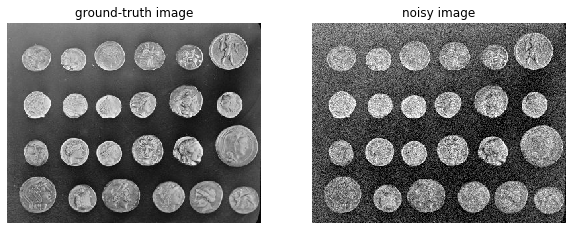

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import random_noise

# load test image 
image = data.coins()

# add noise
sigma = .1
image_noisy = random_noise(image, mode='gaussian', var=sigma**2)

# plot
fig, ax = plt.subplots(1,2,figsize=(10,10))

for i in range(len(ax)):
    ax[i].axis('off')

plt.gray()

ax[0].imshow(image)
ax[0].set_title('ground-truth image')

ax[1].imshow(image_noisy)
ax[1].set_title('noisy image')

plt.show()

1. Take the coins image and add different types and strengths of noise (Gaussian, Laplace, data dependent Poisson) and plot the results. https://scikit-image.org/docs/dev/api/skimage.util.html?highlight=poisson%20noise#skimage.util.random_noise

2. Implement the local linear filter learned in the lecture as an iterative scheme to remove the noise. How can you achieve different degrees of smoothness? What do you observe at edges?

3. Apply also different filters available in skimage (Gaussian, Wiener, etc.). Verify the relationship between the amount of noise you add to the image and the strength of the filter you have to apply. Plot a graph with different PSNR values for different smoothness parameters to validate the "best" result. https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filter#module-skimage.filters

4. Apply the nonlinear total variation (TV) denoising filter (Chambolle version) to your previous test scenario. Verify the preservation of edges of the coins. Vary the regularization paramter. What is the systematic error of TV denoising?
https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html?highlight=noise